In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import csv

In [2]:
import tensorflow as tf

2023-04-12 20:05:44.154242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 20:05:45.023501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-12 20:05:45.023574: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-12 20:05:45.023582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [3]:
import platform
import time
import pathlib
import os

In [4]:
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.8.5
Tensorflow version: 2.11.0
Keras version: 2.11.0


In [5]:
def load_dataset(csv_file_path, silent=False):
    dataset = []

    with open(csv_file_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            dataset.append(row)

        if silent == False:
            print(csv_file_path)
            print('===========================================')
            print('Number of examples: ', len(dataset), '\n')
            print('Example object keys:\n', dataset[0].keys(), '\n')
            print('Example object:\n', dataset[0], '\n')
            print('Required keys:\n')
            print('  title: ', dataset[0]['Title'], '\n')
            print('  ingredients: ', dataset[0]['Ingredients'], '\n')
            print('  totaltime: ', dataset[0]['TotalTimeInMins'], '\n')
            print('  cusine: ', dataset[0]['Cuisine'], '\n')
            print('  instructions: ', dataset[0]['Instructions'],'\n')
            print('  url: ', dataset[0]['URL'], '\n')
            print('  cleanedingredients: ', dataset[0]['Cleaned-Ingredients'], '\n')
            print('  imageurl: ', dataset[0]['image-url'], '\n')
            print('  ingredientcount: ', dataset[0]['Ingredient-count'])
            print('\n\n')

    return dataset

In [6]:
dataset_raw = load_dataset('Cleaned_Indian_Food_Dataset.csv')

Cleaned_Indian_Food_Dataset.csv
Number of examples:  5938 

Example object keys:
 dict_keys(['Title', 'Ingredients', 'TotalTimeInMins', 'Cuisine', 'Instructions', 'URL', 'Cleaned-Ingredients', 'image-url', 'Ingredient-count']) 

Example object:
 {'Title': 'Masala Karela Recipe', 'Ingredients': '1 tablespoon Red Chilli powder,3 tablespoon Gram flour (besan),2 teaspoons Cumin seeds (Jeera),1 tablespoon Coriander Powder (Dhania),2 teaspoons Turmeric powder (Haldi),Salt - to taste,1 tablespoon Amchur (Dry Mango Powder),6 Karela (Bitter Gourd/ Pavakkai) - deseeded,Sunflower Oil - as required,1 Onion - thinly sliced', 'TotalTimeInMins': '45', 'Cuisine': 'Indian', 'Instructions': 'To begin making the Masala Karela Recipe,de-seed the karela and slice.\nDo not remove the skin as the skin has all the nutrients.\nAdd the karela to the pressure cooker with 3 tablespoon of water, salt and turmeric powder and pressure cook for three whistles.\nRelease the pressure immediately and open the lids.\nKee

In [7]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  5938


In [8]:
def recipe_validate_required_fields(recipe):
    required_keys = ['Title', 'Ingredients', 'TotalTimeInMins','Cuisine','Instructions','URL','Cleaned-Ingredients','image-url','Ingredient-count']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [9]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of incomplete recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 5938
Dataset size AFTER validation 5938
Number of incomplete recipes 0


In [10]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_TOTALTIMEINMINS = '\n⌛ '
STOP_WORD_CUISINE = '\n🍛 '
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'
STOP_WORD_URL = '\n🌐 '
STOP_WORD_CLEANEDINGREDIENTS = '\n🍔\n\n'
STOP_WORD_IMAGEURL = '\n📷 '
STOP_WORD_INGREDIENTCOUNT = '\n🥗 '

In [11]:
print(dataset_validated[0])

{'Title': 'Masala Karela Recipe', 'Ingredients': '1 tablespoon Red Chilli powder,3 tablespoon Gram flour (besan),2 teaspoons Cumin seeds (Jeera),1 tablespoon Coriander Powder (Dhania),2 teaspoons Turmeric powder (Haldi),Salt - to taste,1 tablespoon Amchur (Dry Mango Powder),6 Karela (Bitter Gourd/ Pavakkai) - deseeded,Sunflower Oil - as required,1 Onion - thinly sliced', 'TotalTimeInMins': '45', 'Cuisine': 'Indian', 'Instructions': 'To begin making the Masala Karela Recipe,de-seed the karela and slice.\nDo not remove the skin as the skin has all the nutrients.\nAdd the karela to the pressure cooker with 3 tablespoon of water, salt and turmeric powder and pressure cook for three whistles.\nRelease the pressure immediately and open the lids.\nKeep aside.Heat oil in a heavy bottomed pan or a kadhai.\nAdd cumin seeds and let it sizzle.Once the cumin seeds have sizzled, add onions and saute them till it turns golden brown in color.Add the karela, red chilli powder, amchur powder, coriander 

In [12]:
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['Title']
    ingredients = recipe['Ingredients'].split(',')
    totaltimeinmins = recipe['TotalTimeInMins']
    cuisine = recipe['Cuisine']
    instructions = recipe['Instructions'].split('\n')
    url = recipe['URL']
    cleanedingredients = recipe['Cleaned-Ingredients'].split(',')
    imageurl = recipe['image-url']
    ingredientcount = recipe['Ingredient-count']
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'    # adding bullets to structure the data
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'    # adding bullets to structure the data
            
    cleanedingredients_string = ''
    for cleanedingredient in cleanedingredients:
        cleanedingredient = cleanedingredient.replace(noize_string, '')
        if cleanedingredient:
            cleanedingredients_string += f'• {cleanedingredient}\n'    # adding bullets to structure the data
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_TOTALTIMEINMINS}{totaltimeinmins}\n{STOP_WORD_CUISINE}{cuisine}\n{STOP_WORD_INSTRUCTIONS}{instructions_string}{STOP_WORD_URL}{url}\n{STOP_WORD_CLEANEDINGREDIENTS}{cleanedingredients_string}{STOP_WORD_IMAGEURL}{imageurl}\n{STOP_WORD_INGREDIENTCOUNT}{ingredientcount}\n'


In [13]:
print(recipe_to_string(dataset_validated[0]))

📗 Masala Karela Recipe

🥕

• 1 tablespoon Red Chilli powder
• 3 tablespoon Gram flour (besan)
• 2 teaspoons Cumin seeds (Jeera)
• 1 tablespoon Coriander Powder (Dhania)
• 2 teaspoons Turmeric powder (Haldi)
• Salt - to taste
• 1 tablespoon Amchur (Dry Mango Powder)
• 6 Karela (Bitter Gourd/ Pavakkai) - deseeded
• Sunflower Oil - as required
• 1 Onion - thinly sliced

⌛ 45

🍛 Indian

📝

▪︎ To begin making the Masala Karela Recipe,de-seed the karela and slice.
▪︎ Do not remove the skin as the skin has all the nutrients.
▪︎ Add the karela to the pressure cooker with 3 tablespoon of water, salt and turmeric powder and pressure cook for three whistles.
▪︎ Release the pressure immediately and open the lids.
▪︎ Keep aside.Heat oil in a heavy bottomed pan or a kadhai.
▪︎ Add cumin seeds and let it sizzle.Once the cumin seeds have sizzled, add onions and saute them till it turns golden brown in color.Add the karela, red chilli powder, amchur powder, coriander powder and besan.
▪︎ Stir to combin

In [14]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]
print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  5938


In [15]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Masala Karela Recipe

🥕

• 1 tablespoon Red Chilli powder
• 3 tablespoon Gram flour (besan)
• 2 teaspoons Cumin seeds (Jeera)
• 1 tablespoon Coriander Powder (Dhania)
• 2 teaspoons Turmeric powder (Haldi)
• Salt - to taste
• 1 tablespoon Amchur (Dry Mango Powder)
• 6 Karela (Bitter Gourd/ Pavakkai) - deseeded
• Sunflower Oil - as required
• 1 Onion - thinly sliced

⌛ 45

🍛 Indian

📝

▪︎ To begin making the Masala Karela Recipe,de-seed the karela and slice.
▪︎ Do not remove the skin as the skin has all the nutrients.
▪︎ Add the karela to the pressure cooker with 3 tablespoon of water, salt and turmeric powder and pressure cook for three whistles.
▪︎ Release the pressure immediately and open the lids.
▪︎ Keep aside.Heat oil in a heavy bottomed pan or a kadhai.
▪︎ Add cumin seeds and let it sizzle.Once the cumin seeds have sizzled, add onions and saute them till it turns golden brown in color.Add the karela, red chilli powder, amchur powder, coriander powder and besa

In [16]:
print(dataset_stringified[1000])

📗 Mushroom & Goat Cheese Omelette with Spinach Recipe

🥕

• Salt - to taste
• 4 Spinach Leaves (Palak) - torn
• 1/4 cup Milk
• 100 grams Button mushrooms - quatered
• 1 tablespoon Butter
• 50 grams Goat Cheese
• Sunflower Oil
• 2 Whole Eggs
• 1 teaspoon Black pepper powder
• 1 teaspoon Dried oregano

⌛ 30

🍛 Continental

📝

▪︎ To begin making the Mushroom & Goat Cheese Omeltte with Spinach Recipe, break the eggs into a bowl, add milk and sprinkle some salt and whisk till it combines well.Heat a flat skillet with oil, add mushroom and saute until all the water has been evaporated.
▪︎ Sprinkle with little salt.Once the mushroom is cooked, add dried oregano and pepper powder and mix well.
▪︎ Toss well and transfer it to a bowl.Heat a flat nonstick skillet to make the omelette, add a tablespoon of butter.
▪︎ Keep the heat to medium and slowly add the whisked eggs.Allow the egg to cook for 5 minutes.
▪︎ Add sautéed mushroom, torn spinach leaves and crumbled goat cheese to one side and fold 

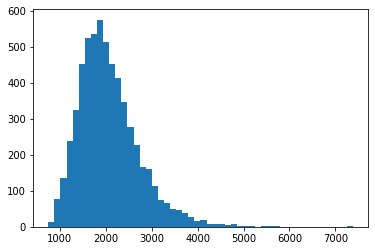

In [17]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, bins=50)
plt.show()

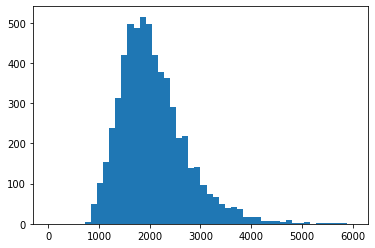

In [18]:
plt.hist(recipes_lengths, range=(0, 6000), bins=50)
plt.show()

In [19]:
MAX_RECIPE_LENGTH = 5500

In [20]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  5938
Dataset size AFTER filtering:  5934
Number of eliminated recipes:  4


In [21]:

TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
     

MAX_RECIPE_LENGTH:  5500
TOTAL_RECIPES_NUM:  5934


In [22]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(dataset_filtered)

tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 5935,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 5934, " ": 1838116, "M": 23779, "a": 873324, "s": 494789, "l": 431453, "K": 13848, "r": 552474, "e": 1065807, "R": 38916, "c": 349837, "i": 624962, "p": 290139, "\\n": 309342, "\\ud83e\\udd55": 5934, "\\u2022": 142379, "1": 64011, "t": 684925, "b": 104342, "o": 640914, "n": 579266, "d": 389326, "C": 46774, "h": 394279, "w": 168510, "3": 10383, "G": 19437, "m": 218201, "f": 123182, "u": 255361, "(": 43399, ")": 43230, "2": 32408, "J": 4252, "P": 30388, "D": 15959, "T": 27293, "H": 9446, "S": 49108, "-": 83545, "A": 30141, "y": 93244, "g": 184925, "6": 4003, "B": 21417, "/": 80366, "v": 65025, "k": 129152, "O": 17284, "q": 4385, "\\u231b": 5934, "4": 13093, "5": 10450, "\\ud83c\\udf5b": 5934, "I": 11324, "\\ud83d\\udcdd": 5934, "\\u25aa": 48283, "\\ufe0e": 48283, ",": 59261, ".": 115702, "z": 10583, "x": 204

In [23]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  154


In [24]:
for i in range(1,154):
  print(tokenizer.index_word[i],end=" ")

  e a t o i n r s l h d c 
 p u m g w • k f . b y - / v 1 , S ▪ ︎ C ( ) R _ 2 P A T j M B x G 0 O D K 4 : W I F z 5 3 H L N 📗 🥕 ⌛ 🍛 📝 🌐 🍔 📷 🥗 E V q J 6 Y 8 & U 7 9 ; ' é Q Z ’ | * " + ! ﻿ ‘ ½ – ° ” X % “ ¼ ñ è ] á [ ì = α Æ ¾ ″ ` ç ˚ च Μ υ ρ ο μ ά τ ι κ ~ ⅓ ö ｜ â ␣ < — ​   × ब ड़ े म ् ह ी ं ग ó ⅔ @ { } ℃ 

In [25]:
tokenizer.word_index['r']

8

In [26]:
array_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in array_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'i', 'n', 'r', 's', 'l', 'h', 'd', 'c', '\n', 'p', 'u', 'm', 'g', 'w', '•', 'k', 'f', '.', 'b', 'y', '-', '/', 'v', '1', ',', 'S', '▪', '︎', 'C', '(', ')', 'R', '_', '2', 'P', 'A', 'T', 'j', 'M', 'B', 'x', 'G', '0', 'O', 'D', 'K', '4', ':', 'W', 'I', 'F', 'z', '5', '3', 'H', 'L', 'N', '📗', '🥕', '⌛', '🍛', '📝', '🌐', '🍔', '📷', '🥗', 'E', 'V', 'q', 'J', '6', 'Y', '8', '&', 'U', '7', '9', ';', "'", 'é', 'Q', 'Z', '’', '|', '*', '"', '+', '!', '\ufeff', '‘', '½', '–', '°', '”', 'X', '%', '“', '¼', 'ñ', 'è', ']', 'á', '[', 'ì', '=', 'α', 'Æ', '¾', '″', '`', 'ç', '˚', 'च', 'Μ', 'υ', 'ρ', 'ο', 'μ', 'ά', 'τ', 'ι', 'κ', '~', '⅓', 'ö', '｜', 'â', '␣', '<', '—', '\u200b', '\u2009', '×', 'ब', 'ड़', 'े', 'म', '्', 'ह', 'ी', 'ं', 'ग', 'ó', '⅔', '@', '{', '}', '℃']


In [27]:
tokenizer.texts_to_sequences(['📗 yes'])

[[63, 1, 25, 2, 9]]

In [28]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 5934


In [29]:
dataset_vectorized[0]

[63,
 1,
 44,
 3,
 9,
 3,
 10,
 3,
 1,
 51,
 3,
 8,
 2,
 10,
 3,
 1,
 37,
 2,
 13,
 6,
 15,
 2,
 14,
 14,
 64,
 14,
 14,
 20,
 1,
 29,
 1,
 4,
 3,
 24,
 10,
 2,
 9,
 15,
 5,
 5,
 7,
 1,
 37,
 2,
 12,
 1,
 34,
 11,
 6,
 10,
 10,
 6,
 1,
 15,
 5,
 19,
 12,
 2,
 8,
 14,
 20,
 1,
 59,
 1,
 4,
 3,
 24,
 10,
 2,
 9,
 15,
 5,
 5,
 7,
 1,
 47,
 8,
 3,
 17,
 1,
 22,
 10,
 5,
 16,
 8,
 1,
 35,
 24,
 2,
 9,
 3,
 7,
 36,
 14,
 20,
 1,
 39,
 1,
 4,
 2,
 3,
 9,
 15,
 5,
 5,
 7,
 9,
 1,
 34,
 16,
 17,
 6,
 7,
 1,
 9,
 2,
 2,
 12,
 9,
 1,
 35,
 75,
 2,
 2,
 8,
 3,
 36,
 14,
 20,
 1,
 29,
 1,
 4,
 3,
 24,
 10,
 2,
 9,
 15,
 5,
 5,
 7,
 1,
 34,
 5,
 8,
 6,
 3,
 7,
 12,
 2,
 8,
 1,
 40,
 5,
 19,
 12,
 2,
 8,
 1,
 35,
 50,
 11,
 3,
 7,
 6,
 3,
 36,
 14,
 20,
 1,
 39,
 1,
 4,
 2,
 3,
 9,
 15,
 5,
 5,
 7,
 9,
 1,
 42,
 16,
 8,
 17,
 2,
 8,
 6,
 13,
 1,
 15,
 5,
 19,
 12,
 2,
 8,
 1,
 35,
 60,
 3,
 10,
 12,
 6,
 36,
 14,
 20,
 1,
 31,
 3,
 10,
 4,
 1,
 26,
 1,
 4,
 5,
 1,
 4,
 3,
 9,
 4,
 2,
 14,
 20,
 1,
 2

In [30]:
print(dataset_vectorized[0][:10], '...')

[63, 1, 44, 3, 9, 3, 10, 3, 1, 51] ...


In [31]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

recipe_sequence_to_string(dataset_vectorized[0])

📗   M a s a l a   K a r e l a   R e c i p e 
 
 🥕 
 
 •   1   t a b l e s p o o n   R e d   C h i l l i   p o w d e r 
 •   3   t a b l e s p o o n   G r a m   f l o u r   ( b e s a n ) 
 •   2   t e a s p o o n s   C u m i n   s e e d s   ( J e e r a ) 
 •   1   t a b l e s p o o n   C o r i a n d e r   P o w d e r   ( D h a n i a ) 
 •   2   t e a s p o o n s   T u r m e r i c   p o w d e r   ( H a l d i ) 
 •   S a l t   -   t o   t a s t e 
 •   1   t a b l e s p o o n   A m c h u r   ( D r y   M a n g o   P o w d e r ) 
 •   6   K a r e l a   ( B i t t e r   G o u r d /   P a v a k k a i )   -   d e s e e d e d 
 •   S u n f l o w e r   O i l   -   a s   r e q u i r e d 
 •   1   O n i o n   -   t h i n l y   s l i c e d 
 
 ⌛   4 5 
 
 🍛   I n d i a n 
 
 📝 
 
 ▪ ︎   T o   b e g i n   m a k i n g   t h e   M a s a l a   K a r e l a   R e c i p e , d e - s e e d   t h e   k a r e l a   a n d   s l i c e . 
 ▪ ︎   D o   n o t   r e m o v e   t h e   s k i n   a s   t h e   s k i n 

In [32]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 1721
Recipe #2 length: 1422
Recipe #3 length: 1885
Recipe #4 length: 2682
Recipe #5 length: 1418
Recipe #6 length: 2033
Recipe #7 length: 2217
Recipe #8 length: 1944
Recipe #9 length: 1661
Recipe #10 length: 1629


In [33]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
print(dataset_vectorized_padded_without_stops[0][:15])

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
print(dataset_vectorized_padded[0][:17])

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

[63  1 44  3  9  3 10  3  1 51  3  8  2 10  3]
[63  1 44  3  9  3 10  3  1 51  3  8  2 10  3  1 37]
Recipe #0 length: 5501
Recipe #1 length: 5501
Recipe #2 length: 5501
Recipe #3 length: 5501
Recipe #4 length: 5501
Recipe #5 length: 5501
Recipe #6 length: 5501
Recipe #7 length: 5501
Recipe #8 length: 5501
Recipe #9 length: 5501


In [34]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗   M a s a l a   K a r e l a   R e c i p e 
 
 🥕 
 
 •   1   t a b l e s p o o n   R e d   C h i l l i   p o w d e r 
 •   3   t a b l e s p o o n   G r a m   f l o u r   ( b e s a n ) 
 •   2   t e a s p o o n s   C u m i n   s e e d s   ( J e e r a ) 
 •   1   t a b l e s p o o n   C o r i a n d e r   P o w d e r   ( D h a n i a ) 
 •   2   t e a s p o o n s   T u r m e r i c   p o w d e r   ( H a l d i ) 
 •   S a l t   -   t o   t a s t e 
 •   1   t a b l e s p o o n   A m c h u r   ( D r y   M a n g o   P o w d e r ) 
 •   6   K a r e l a   ( B i t t e r   G o u r d /   P a v a k k a i )   -   d e s e e d e d 
 •   S u n f l o w e r   O i l   -   a s   r e q u i r e d 
 •   1   O n i o n   -   t h i n l y   s l i c e d 
 
 ⌛   4 5 
 
 🍛   I n d i a n 
 
 📝 
 
 ▪ ︎   T o   b e g i n   m a k i n g   t h e   M a s a l a   K a r e l a   R e c i p e , d e - s e e d   t h e   k a r e l a   a n d   s l i c e . 
 ▪ ︎   D o   n o t   r e m o v e   t h e   s k i n   a s   t h e   s k i n 

In [35]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(5501,), dtype=tf.int32, name=None)>


In [36]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 63   1  44 ... 133 133 133] 



Stringified recipe:

📗   M a s a l a   K a r e l a   R e c i p e 
 
 🥕 
 
 •   1   t a b l e s p o o n   R e d   C h i l l i   p o w d e r 
 •   3   t a b l e s p o o n   G r a m   f l o u r   ( b e s a n ) 
 •   2   t e a s p o o n s   C u m i n   s e e d s   ( J e e r a ) 
 •   1   t a b l e s p o o n   C o r i a n d e r   P o w d e r   ( D h a n i a ) 
 •   2   t e a s p o o n s   T u r m e r i c   p o w d e r   ( H a l d i ) 
 •   S a l t   -   t o   t a s t e 
 •   1   t a b l e s p o o n   A m c h u r   ( D r y   M a n g o   P o w d e r ) 
 •   6   K a r e l a   ( B i t t e r   G o u r d /   P a v a k k a i )   -   d e s e e d e d 
 •   S u n f l o w e r   O i l   -   a s   r e q u i r e d 
 •   1   O n i o n   -   t h i n l y   s l i c e d 
 
 ⌛   4 5 
 
 🍛   I n d i a n 
 
 📝 
 
 ▪ ︎   T o   b e g i n   m a k i n g   t h e   M a s a l a   K a r e l a   R e c i p e , d e - s e e d   t h e   k a r e l a   a n d   s l i c e . 
 ▪ ︎   

In [37]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset element_spec=(TensorSpec(shape=(5500,), dtype=tf.int32, name=None), TensorSpec(shape=(5500,), dtype=tf.int32, name=None))>


In [38]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified))) 

Input sequence size: 5500
Target sequence size: 5500

Input:   '📗   M a s a l a   K a r e l a   R e c i p e \n \n 🥕 \n \n •   1   t a b l e s p o o n   R e d   C h i l'
Target:  '  M a s a l a   K a r e l a   R e c i p e \n \n 🥕 \n \n •   1   t a b l e s p o o n   R e d   C h i l l'


In [39]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 63 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 44 ('M')
Step  3
  input: 44 ('M')
  expected output: 3 ('a')
Step  4
  input: 3 ('a')
  expected output: 9 ('s')
Step  5
  input: 9 ('s')
  expected output: 3 ('a')
Step  6
  input: 3 ('a')
  expected output: 10 ('l')
Step  7
  input: 10 ('l')
  expected output: 3 ('a')
Step  8
  input: 3 ('a')
  expected output: 1 (' ')
Step  9
  input: 1 (' ')
  expected output: 51 ('K')
Step 10
  input: 51 ('K')
  expected output: 3 ('a')


In [40]:
print(dataset_targeted)

<MapDataset element_spec=(TensorSpec(shape=(5500,), dtype=tf.int32, name=None), TensorSpec(shape=(5500,), dtype=tf.int32, name=None))>


In [41]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  5934
MAX_RECIPE_LENGTH:  5500
VOCABULARY_SIZE:  154


In [42]:

# Batch size.
BATCH_SIZE = 16

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 100

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat() 
  # \
  # Shuffling examples first. \
  # Splitting examples on batches. \
  # Making a dataset to be repeatable (it will never ends). 
  

print(dataset_train)

<RepeatDataset element_spec=(TensorSpec(shape=(16, 5500), dtype=tf.int32, name=None), TensorSpec(shape=(16, 5500), dtype=tf.int32, name=None))>


In [43]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 63   1  34 ... 133 133 133]
 [ 63   1  31 ... 133 133 133]
 [ 63   1  80 ... 133 133 133]
 ...
 [ 63   1  40 ... 133 133 133]
 [ 63   1  37 ... 133 133 133]
 [ 63   1  34 ... 133 133 133]], shape=(16, 5500), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  34  11 ... 133 133 133]
 [  1  31  15 ... 133 133 133]
 [  1  80  12 ... 133 133 133]
 ...
 [  1  40   2 ... 133 133 133]
 [  1  37   5 ... 133 133 133]
 [  1  34  11 ... 133 133 133]], shape=(16, 5500), dtype=int32)


In [44]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 61ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[2 4 5 7 8 6 5 5]
 [5 4 5 4 0 6 1 6]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.0465762   0.02893068  0.04156489 -0.04801992 -0.00650096]
  [-0.01114875  0.0124165   0.02126211 -0.03550124  0.03258998]
  [ 0.01953992 -0.03842988 -0.04963877  0.03643965  0.02574452]
  [ 0.01737254  0.03647811  0.04181746 -0.01024995 -0.0451902 ]
  [-0.00797472  0.01435146 -0.04461931  0.02003052  0.02440539]
  [-0.03171824  0.03415085  0.04318965 -0.00399424 -0.02049167]
  [ 0.01953992 -0.03842988 -0.04963877  0.03643965  0.02574452]
  [ 0.01953992 -0.03842988 -0.04963877  0.03643965  0.02574452]]

 [[ 0.01953992 -0.03842988 -0.04963877  0.03643965  0.02574452]
  [-0.01114875  0.0124165   0.02126211 -0.03550124  0.03258998]
  [ 0.01953992 -0.03842988 -0.04963877  0.03643965  0.02574452]
  [-0.01114875  0.0124165   0.02126211 -0.03550124  0.03258998]
  [ 0.00617354 -0.02050952 -0.02704324 

In [45]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (16, None, 256)           39424     
                                                                 
 lstm (LSTM)                 (16, None, 1024)          5246976   
                                                                 
 dense (Dense)               (16, None, 154)           157850    
                                                                 
Total params: 5,444,250
Trainable params: 5,444,250
Non-trainable params: 0
_________________________________________________________________


In [46]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [47]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [48]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [49]:

for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
     

(16, 5500, 154) # (batch_size, sequence_length, vocab_size)


In [50]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-4.8817694e-03  1.9801507e-04 -1.5280609e-03 -2.3191678e-03
  6.8645757e-03  7.6462823e-04  1.6103250e-03 -1.4124127e-03
  5.6006173e-03 -4.3630265e-03 -2.4929435e-03 -3.6169435e-03
 -5.5917527e-04  1.6152102e-03 -1.8562538e-03  3.7493207e-04
  7.2407932e-04 -6.4716330e-03  3.8224773e-04  3.5385289e-03
  1.3478119e-03 -8.9375116e-04 -2.0827923e-03  1.7523407e-03
 -1.8584195e-03 -1.1441391e-03 -3.4636715e-03  7.4369385e-04
 -1.4835250e-03  3.6288607e-03  4.9392455e-03  6.3400487e-03
 -6.7830575e-04  2.8785407e-03  4.9898443e-03 -3.4335733e-03
 -1.0825689e-03  4.4813403e-03 -3.7201345e-03  6.4033305e-04
  5.3127692e-04 -8.7838189e-04 -3.5548555e-03  1.4114352e-03
  4.2325351e-03  9.5654791e-04 -1.4608077e-03 -4.8447656e-04
 -6.9947606e-03  6.1383704e-04  2.1433027e-03  3.4971372e-03
 -2.7298713e-03  1.1203984e-03  1.5544466e-03 -2.0658784e-04
 -4.1725296e-03  6.4437860e-04 -1.8412692e-03 -3.8350616e-03
  2.7504964e-03  

In [51]:
# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0"
# (element with index 0) is low but the probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 2 1 1 0]], shape=(1, 5), dtype=int64)


In [52]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(5500,)

In [53]:
sampled_indices[:100]

array([149,  36,  34, 146,  24,  72,  28,  14,  30, 152,  47,  36, 140,
        57,  85,  73, 153,   0,  94,  84, 137, 111,  29,  40, 138,  44,
         1,  32,  44, 117,  81,  67, 115,  25,  45, 149, 120,  33, 129,
       112, 136,  20,  21, 111,  38,  15, 145,  72, 135,  43, 132,  91,
       152,  57, 130,  45,  51,  97,  68, 131,  25,  66,  62, 146, 123,
        39,  62,  29,  38,  96,  46,  59, 109, 142,  58,  79,   3, 117,
        14,   6, 127,   4,  46, 108, 151,  54, 147,  33,  33, 106,  67,
        77,   2, 144,  30,   9,  19, 109,   4,  27])

In [54]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗   R o a s t e d   C a u l i f l o w e r   R e c i p e \n \n 🥕 \n \n •   3   t a b l e s p o o n   E x'

Next char prediction:
 "⅔ ) C ं b E v \n , } G ) ड़ z é V ℃ \ufeff ' \u2009 α 1 P × M   ▪ M ˚ 7 📝 ` y B ⅔ υ ︎ ⅓ Æ \u200b • k α _ p ी E — j"


In [55]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean()) 

Prediction shape:  (16, 5500, 154)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (16, 5500)
scalar_loss:       5.0503693


In [56]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss='sparse_categorical_crossentropy'
)

In [57]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [58]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [59]:
save_model_callback = tf.keras.callbacks.ModelCheckpoint("Model.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=50)

In [60]:
EPOCHS = 7
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 50

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           7
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  50


In [61]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        save_model_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 2/7
49/50 [============================>.] - ETA: 23s - loss: 2.1300 
Epoch 2: loss improved from inf to 2.11315, saving model to Model.h5
50/50 [==============================] - 1200s 24s/step - loss: 2.1132
Epoch 3/7
49/50 [============================>.] - ETA: 23s - loss: 1.2968 
Epoch 3: loss improved from 2.11315 to 1.29489, saving model to Model.h5
50/50 [==============================] - 1182s 24s/step - loss: 1.2949
Epoch 4/7
49/50 [============================>.] - ETA: 23s - loss: 1.1965 
Epoch 4: loss improved from 1.29489 to 1.19415, saving model to Model.h5
50/50 [==============================] - 1159s 23s/step - loss: 1.1941